# Water Pump Predictive Maintenance 💧 
#### *using unsupervised learning techniques*

### Overview

The problem: In today's society we are bombarded with much data but often do not know how to use that information. This dataset was put on Kaggle so that smart minds could find patterns in the sensor data given by a local water pump. The proposal for this project is to use machine learning to detect patterns in the sensor data so that the pump owners will be better able to understand when a failure is about to occur. 

We begin this project by exploring the data provided. This project will use two unsupervised learning techniques including PCA (for feature extraction and dimensionalty reduction) and KMeans clusters. Then, supervised ML models are used to compare to the unsupervised Kmeans model. Finally, an overview and summary is provided at the end of the notebook. 

### 1. 🧐 Exploratory Data Analysis 

Exploratory data analysis (EDA) is very important when it comes to working with data. In this project we look at all the data first instead of splitting into traing-test sets. Because this notebook is completed for a school project, we will be doing some data anaylsis not normally recommended. For example, looking at all the data before splitting it. The EDA section uses visualizations and performs very preliminary data preprocessing steps, such as deleting empty columns.

### 2. 🤓 Preprocessing

In the preprocessing step, we need to get the most useful parts of the data to feed to the machine learning model. First we will deal with missing data using forward propogation. Then we will use a common unsupervised learning technqiue call Principle Component Analysis (PCA) to reduce the number of sensors used in the next steps. PCA is a great tool for feature reduction.

### 3. 🦾 Modeling

Next, using KMeans clustering (an unsupervised ML model) we will try to determine where the failures are. Because Kmeans is unsupervised, we will use the best model recommendation for number of clusters. To compare our models later, we need to use some sort of performance testing such as accuracy, recall and/or precision. Since, in reality, we do know the labels of the data we can find the best labeling throught permutation. The cavet to this technique is if there are more clusters than given labels, our model may perform poorly according to accuracy, recall or precision. We will discuss this later in the notebook more. 

### 4. 🤜🤛 Model Comparison

After creating a KMeans cluster model, we will build a supervised learning model which also uses clustering such as K-Nearest Neighbors (KNN). We chose to use two clustering models for practice however, other possible models will be discussed in the following section.

### 5. 👏 Conclusions and Future Suggestions

This section includes a brief overview of the project and what was accomplished throughout. We review the different models used and how they performed. For a well-rounded project, we will reflect upon what could have been done differently to have a better model performance as well as things we could have changed in general and what their impact may have been. 

In [1]:
# import necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and modeling
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# global parameters 
RANDOMSTATE = 101

# display file names
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pump-sensor-data/sensor.csv


In [2]:
# load data 
dir_path = '/kaggle/input/pump-sensor-data/'
sensor_data = pd.read_csv(dir_path + 'sensor.csv')

------
# 1. Exploratory Data Analysis (EDA) 🧐

In [3]:
# take a quick look at dataframe 
sensor_data.head()

Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.68287   50.92593  38.194440   157.9861   67.70834   
1  39.641200   65.68287   50.92593  38.194440   157.9861   67.70834   
2  39.351852   65.39352   51.21528  38.194443   155.9606   67.12963   
3  39.062500   64.81481   51.21528  38.194440   155.9606   66.84028   
4  38.773150   65.10416   51.79398  38.773150   158.2755   66.55093   

   sensor_50  sensor_51  machine_status  
0   243.0556   201.3889          NORMAL  
1   243.0556   201.3889          NORMAL  
2   241.3194   203.7037          NORMAL  
3   240.4514   203.1250          NORMAL  
4   242.1875   201.3889          NORMAL  

[5 rows x 55 columns]

In [4]:
sensor_data['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [5]:
# get more info from the dataset 
sensor_data.describe()

Unnamed: 0      sensor_00      sensor_01      sensor_02  \
count  220320.000000  210112.000000  219951.000000  220301.000000   
mean   110159.500000       2.372221      47.591611      50.867392   
std     63601.049991       0.412227       3.296666       3.666820   
min         0.000000       0.000000       0.000000      33.159720   
25%     55079.750000       2.438831      46.310760      50.390620   
50%    110159.500000       2.456539      48.133678      51.649300   
75%    165239.250000       2.499826      49.479160      52.777770   
max    220319.000000       2.549016      56.727430      56.032990   

           sensor_03      sensor_04      sensor_05      sensor_06  \
count  220301.000000  220301.000000  220301.000000  215522.000000   
mean       43.752481     590.673936      73.396414      13.501537   
std         2.418887     144.023912      17.298247       2.163736   
min        31.640620       2.798032       0.000000       0.014468   
25%        42.838539     626.620400      69.976260      13.346350   
50%        44.227428     632.638916      75.576790      13.642940   
75%        45.312500     637.615723      80.912150      14.539930   
max        48.220490     800.000000      99.999880      22.251160   

           sensor_07      sensor_08  ...      sensor_42      sensor_43  \
count  214869.000000  215213.000000  ...  220293.000000  220293.000000   
mean       15.843152      15.200721  ...      35.453455      43.879591   
std         2.201155       2.037390  ...      10.259521      11.044404   
min         0.000000       0.028935  ...      22.135416      24.479166   
25%        15.907120      15.183740  ...      32.812500      39.583330   
50%        16.167530      15.494790  ...      35.156250      42.968750   
75%        16.427950      15.697340  ...      36.979164      46.614580   
max        23.596640      24.348960  ...     374.218800     408.593700   

           sensor_44      sensor_45      sensor_46      sensor_47  \
count  220293.000000  220293.000000  220293.000000  220293.000000   
mean       42.656877      43.094984      48.018585      44.340903   
std        11.576355      12.837520      15.641284      10.442437   
min        25.752316      26.331018      26.331018      27.199070   
25%        36.747684      36.747684      40.509258      39.062500   
50%        40.509260      40.219910      44.849540      42.534720   
75%        45.138890      44.849540      51.215280      46.585650   
max      1000.000000     320.312500     370.370400     303.530100   

           sensor_48      sensor_49      sensor_50      sensor_51  
count  220293.000000  220293.000000  143303.000000  204937.000000  
mean      150.889044      57.119968     183.049260     202.699667  
std        82.244957      19.143598      65.258650     109.588607  
min        26.331018      26.620370      27.488426      27.777779  
25%        83.912030      47.743060     167.534700     179.108800  
50%       138.020800      52.662040     193.865700     197.338000  
75%       208.333300      60.763890     219.907400     216.724500  
max       561.632000     464.409700    1000.000000    1000.000000  

[8 rows x 53 columns]

In [6]:
# get further info from dataset
sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [7]:
# we see that one column (sensor_15) has no values therefore we will delete that column 
sensor_data = sensor_data.drop('sensor_15', axis = 1)

In [8]:
# sensor 50 also is missing 34.95% of its data so we will delete that column as well. 
sensor_data = sensor_data.drop('sensor_50', axis =1) 

In [9]:
# We will delete sensor_00 and sensor_51 which are both missing close to 6-7% of their data. 
# as well as the Unnamed:0 column which is essentially the index column duplicate
sensor_data = sensor_data.drop('Unnamed: 0', axis =1)
sensor_data = sensor_data.drop('sensor_00', axis =1) 
sensor_data = sensor_data.drop('sensor_51', axis =1) 


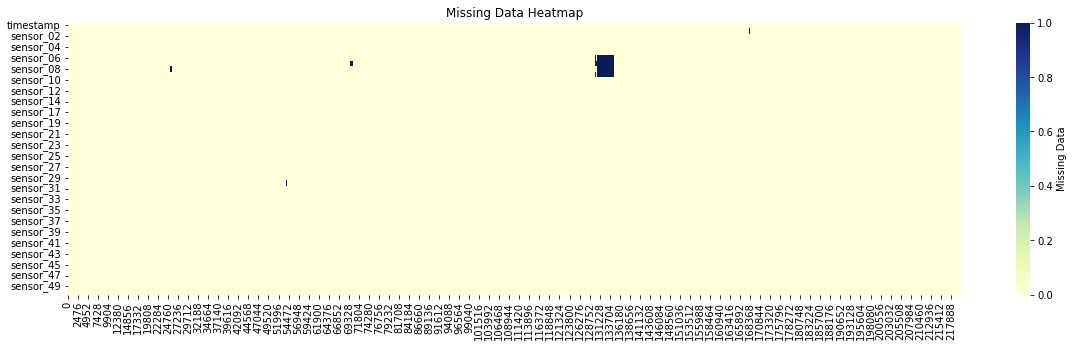

In [10]:
# this cell is hidden for easier notebook readability.
# plot a heatmap of the missing values
plt.figure(figsize=(20,5))
sns.heatmap(sensor_data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.title('Missing Data Heatmap')
plt.show();

We see a large chunk where multiple sensors failed to record at the same time. This could have been caused by weather, electrical malfunction, maintanence, or many other factors. Since this could be an indicator of the system being down, we will leave these in and deal will missing values later on. 


Now we have two options, either we delete the rest of the rows which are missing values. Each column is missing about 2% or less of its data or, we can fill in the missing values. However, before we do anything to the data, we will split it into training and testing data using a 20/80 split. And, since this is timeseries data and we want to try to make predictions as such, we will take the last 20% from the dataset. We could split the data randomly into training and testing but since I really want to try to predict failure in future (predictive maintenance), we will study the first 80% (current history) and try to predict the last 20% (future).

In [11]:
#split data 80/20 with last 20% as the test set
last_40percent = round(len(sensor_data) - len(sensor_data)*.4)
train = sensor_data.iloc[ :last_40percent, :]
test = sensor_data.iloc[last_40percent: ,:]

In [12]:
test[test['machine_status']=='BROKEN']

timestamp  sensor_01  sensor_02  sensor_03   sensor_04  \
141131  2018-07-08 00:11:00  45.138890   52.90799   45.35590  500.000000   
166440  2018-07-25 14:00:00  45.833332   52.99479   43.88021  420.503448   

        sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_41  \
141131    1.40131   0.028935   0.036169   0.036169   0.007234  ...   35.41666   
166440   72.52040  14.185470  16.247110  15.697340  15.053530  ...   35.41666   

        sensor_42  sensor_43  sensor_44  sensor_45  sensor_46  sensor_47  \
141131   32.81250   36.19791   37.32639   35.30093   38.19444   43.40278   
166440   36.45833   51.30208   52.10200   52.66204   67.12963   43.98148   

        sensor_48  sensor_49  machine_status  
141131   99.53703   44.84954          BROKEN  
166440  230.32410   69.73380          BROKEN  

[2 rows x 50 columns]

## ⭐️ Visualization ⭐️

Now that we have our training set ready to go, let's visualize it and explore the data further to get some insights!

In [13]:
# get useful columns and rows
sensor_cols = train.iloc[:,1:49]
broken_rows = train[train['machine_status']=='BROKEN']
recovery_rows = train[train['machine_status']=='RECOVERING']
normal_rows = train[train['machine_status']=='NORMAL']
machine_status_col = train['machine_status']

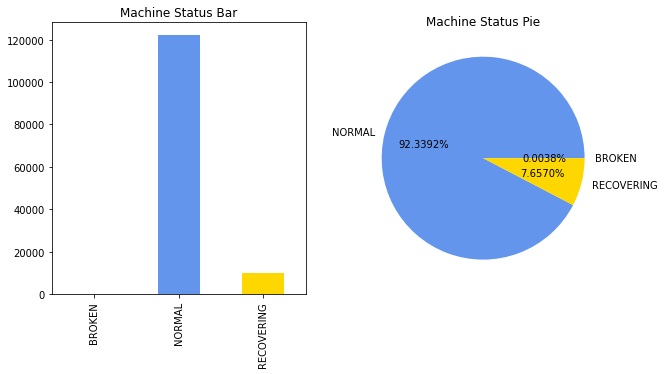

In [14]:
# this cell is hidden for easier notebook readability.

# pie chart of machine status
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
train.groupby('machine_status').size().plot(kind='bar', ax=ax1, color=['black', 'cornflowerblue', 'gold'])
train.groupby('machine_status').size().plot(kind='pie', ax=ax2, autopct='%.4f%%', colors=['black', 'cornflowerblue', 'gold'])
ax1.set_title('Machine Status Bar')
ax1.set_xlabel('')
ax2.set_title('Machine Status Pie')
ax2.set_ylabel('')
plt.show();

As we can see, majority of the time the sensors register NORMAL. This makes sense because the pump should be working normally most of the time. We then see the RECOVERING as the next group, which also makes sense given that the machine breaks then take a bit to recover. Lastly, only 0.004% of the data is in BROKEN status. This is okay because a machine breaks, and in theory, shouldn't be broken for very long. This BROKEN status is what we will try to predict. 

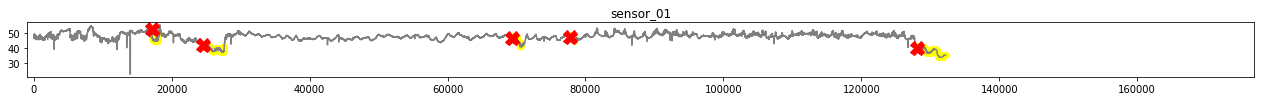

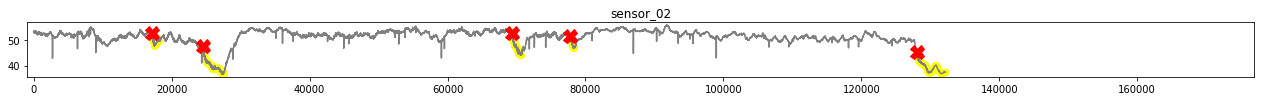

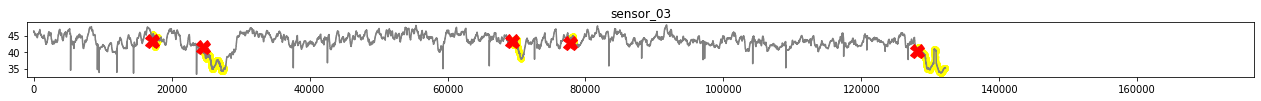

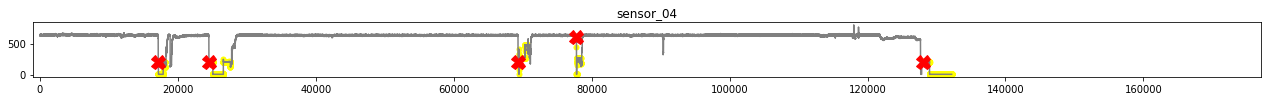

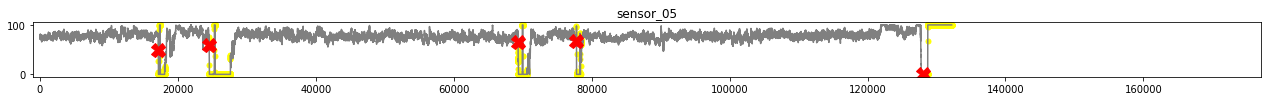

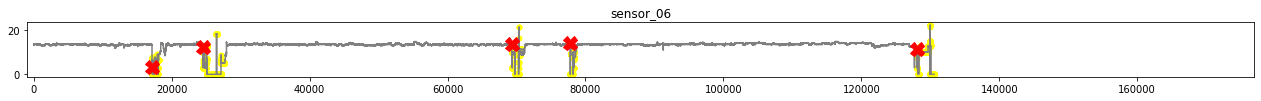

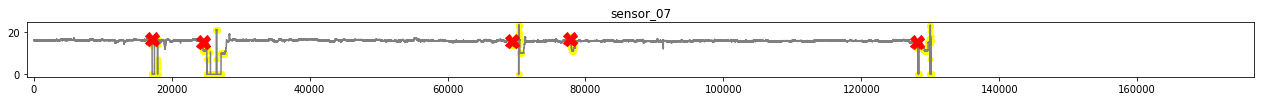

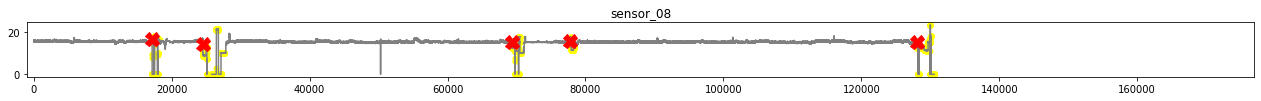

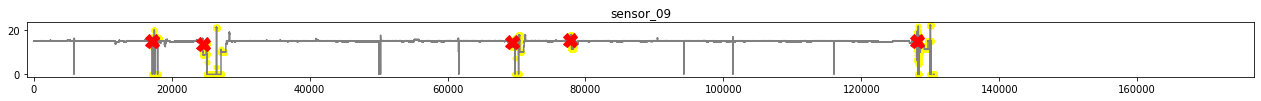

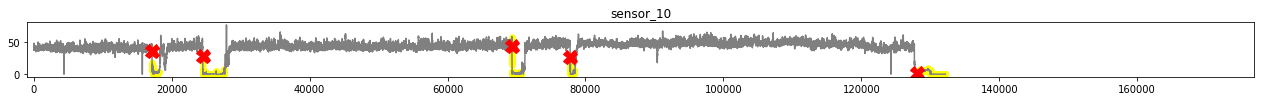

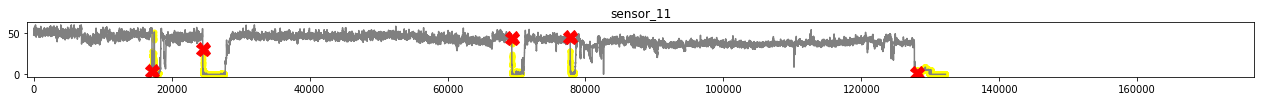

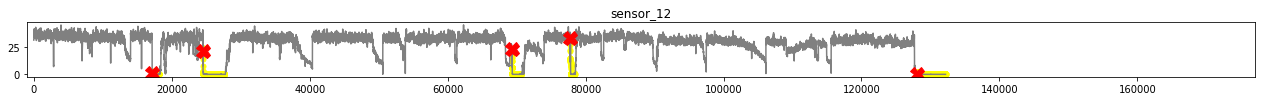

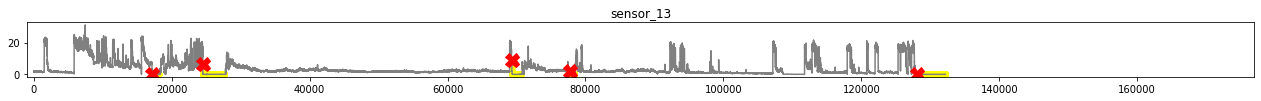

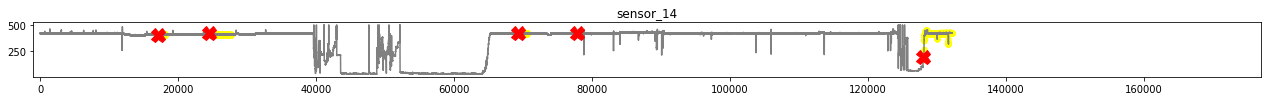

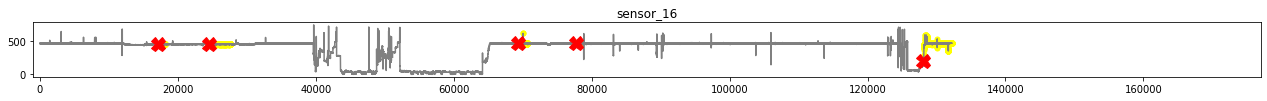

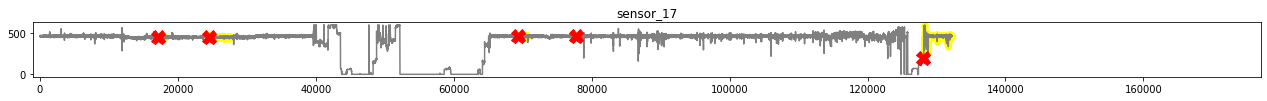

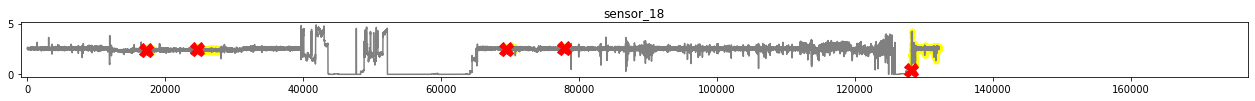

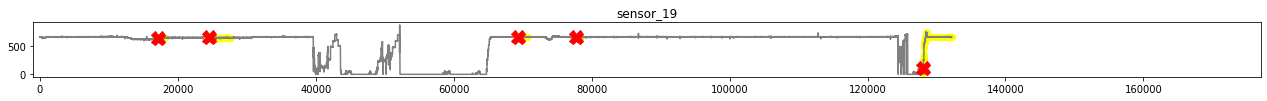

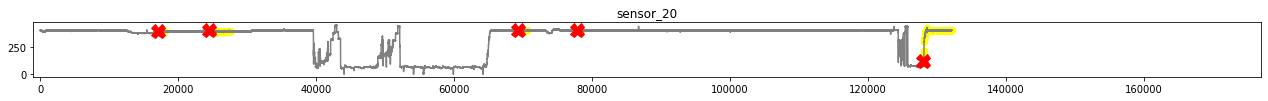

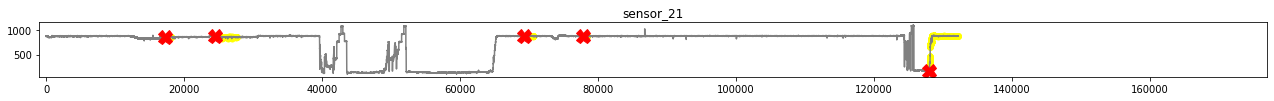

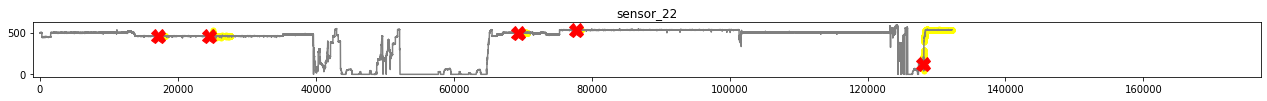

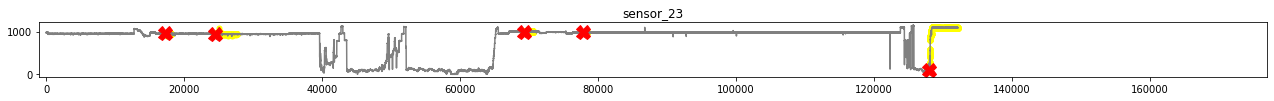

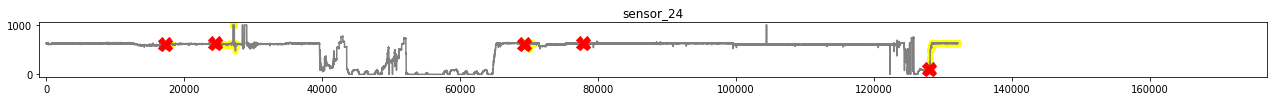

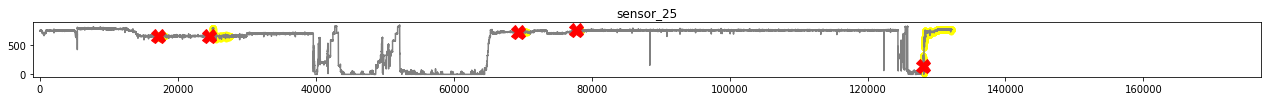

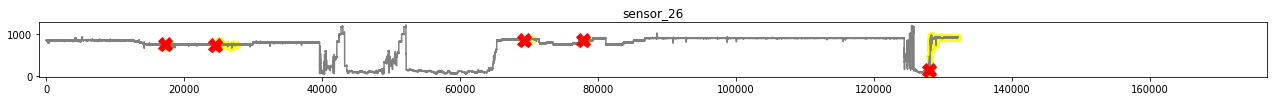

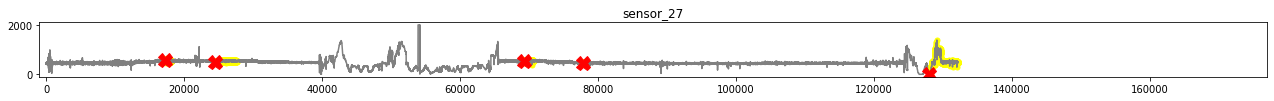

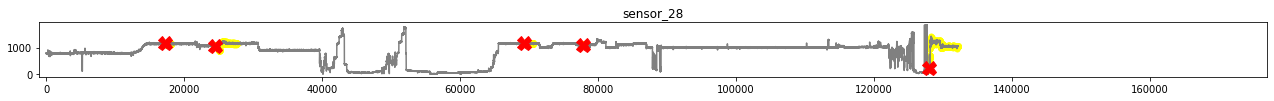

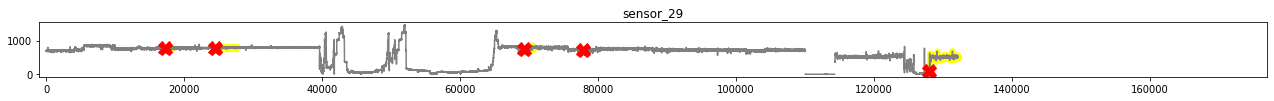

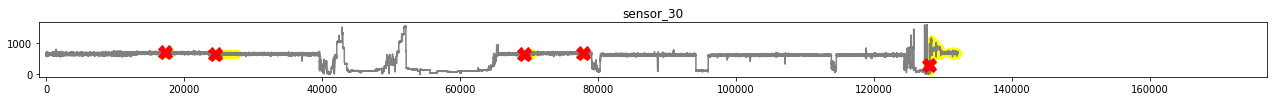

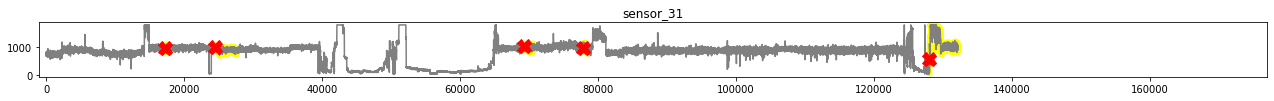

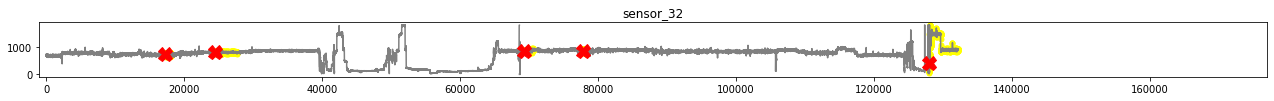

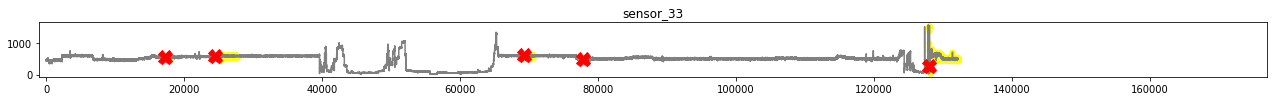

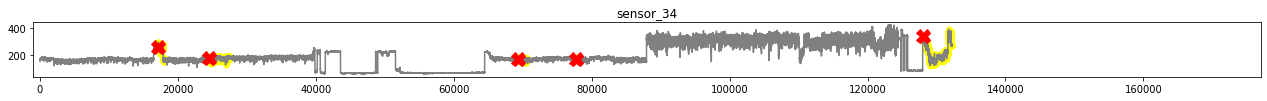

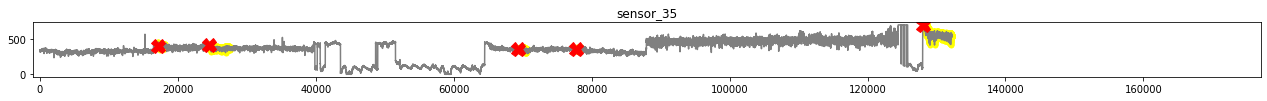

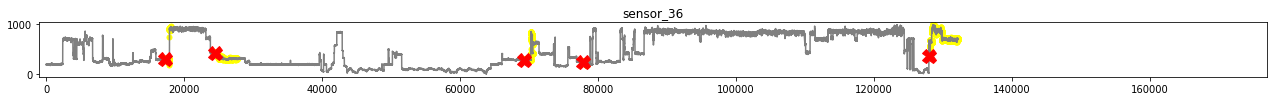

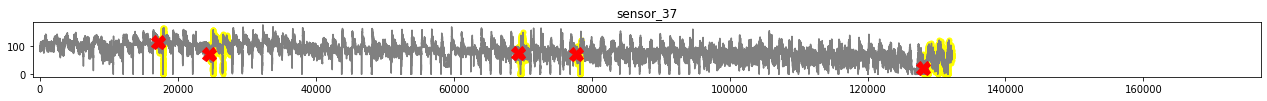

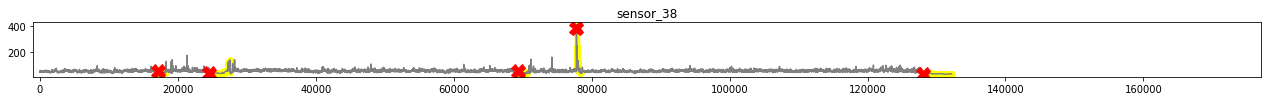

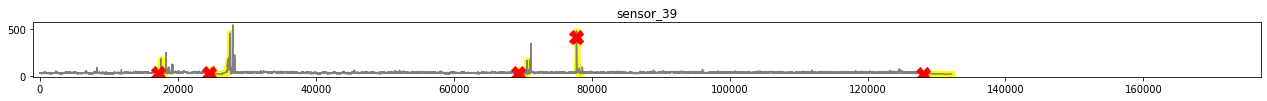

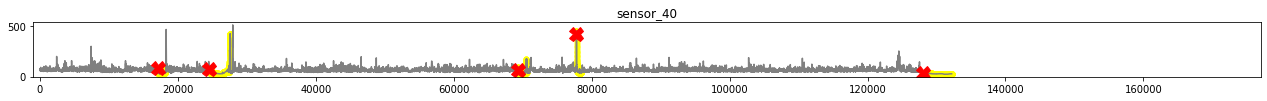

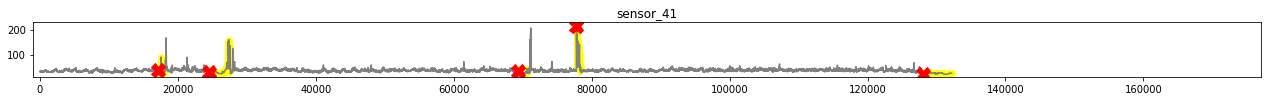

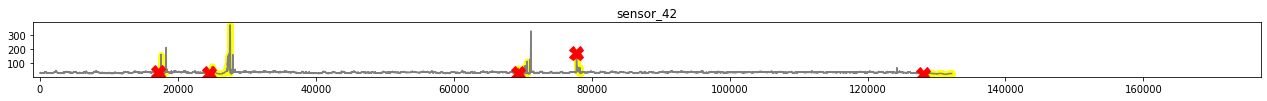

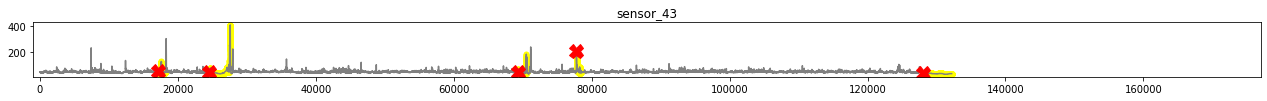

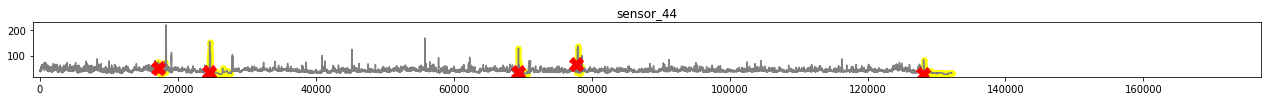

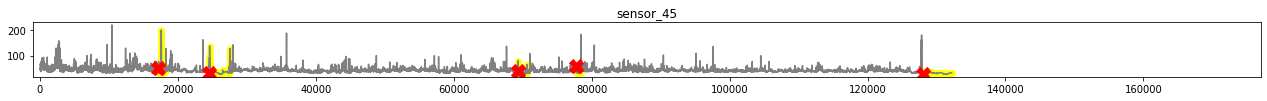

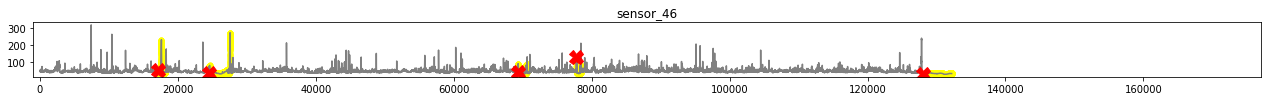

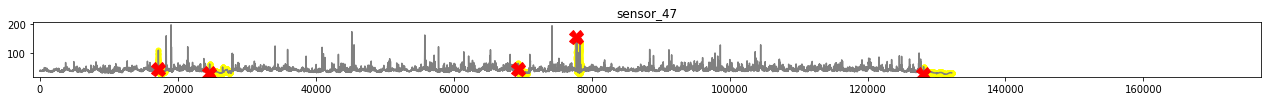

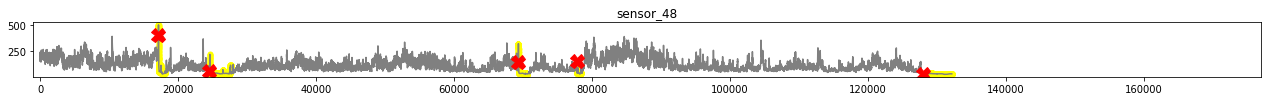

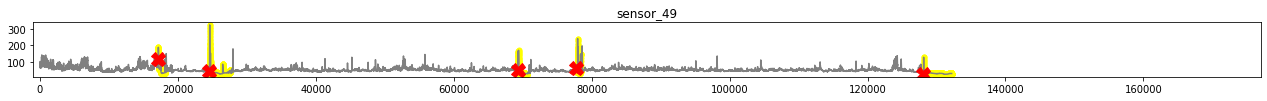

In [42]:
# this cell is hidden for easier notebook readability.

# This visualization loop was inspired from JANANI KARIYAWASAM found at 
# https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering

for sensor in sensor_cols:
    plot = plt.figure(figsize=(22,1))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5)
    plot = plt.plot(train[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14)
    plot = plt.title(sensor)
    plt.xlim((-1000,177000))
    plt.show();

As someone who does not know very much about water pumps and their sensors, we will look at these plots for patterns (as we should anyway). First, we see that many of the plots have large changes around the x-marker 40000-65000 time, as well as around 130000 time. Some sensors drop to very low values, some increase, while others (which are normally consistent) flutter greatly. We see that in these times the machine has failed and is recovering at least once. This could be an indictator for predicting failure. This brings us to the next task: dealing with missing data.

--------
# 2. Preprocessing 🤓

In section 1, we already did a little bit of preprocessing by deleting unnecessary columns. No we will work with missing data. We have a few options when it comes to missing data. We can impute (fill) it with a constant value (such as 0, 10, etc), the mean of that sensor, or even delete those rows. For this project, it seems that the missing values are associated with when the machine goes down. This makes sense because if the machine is down the sensor might go down as well if they are connected. For this reason we will can use forward or backward propogation. 

Next, we will look into feature extraction and dimensionality reduction.

Steps for preprocessing this dataset:
1. Handle missing data
2. Feature extraction and dimensionality reduction

Missing data using forward fill #############################################

In [16]:
# split data into X and y (data and labels)         
X_cols = train.iloc[ : , 1:-1].columns
X_train = train.iloc[:,1:-1].copy()
y_train = train['machine_status']

In [17]:
#fill NA's with forward fill propogation
X_train = X_train.fillna(method='ffill')

Normalization vs Standardization ###############################################################################

https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

In [18]:
# normalize data 
normalize = Normalizer()
X_train = normalize.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X_cols

The curse of dimensionality. PCA for dimensionality reduction #######################################

https://towardsdatascience.com/feature-extraction-using-principal-component-analysis-a-simplified-visual-demo-e5592ced100a

I tried to run a covariance matrix here but the notebook ran out of room. This is such a good example of needing dimensionality reduction! 

*** If 0 < n_components < 1 and svd_solver == 'full', select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

In [19]:
pca = PCA(n_components = .99, svd_solver = 'full', random_state = RANDOMSTATE )
pca.fit(X_train)
pca.n_components_

16

In [20]:
pca.explained_variance_

array([0.09629125, 0.00890455, 0.00644001, 0.0038204 , 0.00263758,
       0.00227281, 0.00158987, 0.00131147, 0.00112446, 0.00102644,
       0.00093835, 0.00073091, 0.00055499, 0.00045077, 0.00043499,
       0.00026746])

In [21]:
# code hidden for easier readability

# it was quite challenging trying to get the sensors (feature names) 
# and print them so that I knew which ones we were working with. For this
# reason, I got help from Amunnelly at 
# https://discuss.dizzycoding.com/recovering-features-names-of-explained_variance_ratio_-in-pca-with-sklearn/

# view the most important features which we will use to train the predictive model 
n_comps = pca.n_components_
most_important_comps = [np.abs(pca.components_[i]).argmax() for i in range(n_comps)]
intital_features = list(X_train.columns)
most_important_sensors = [intital_features[most_important_comps[i]] for i in range(n_comps)]
dic = {'PC{}'.format(i+1): most_important_sensors[i] for i in range(n_comps)}
df = pd.DataFrame(sorted(dic.items()))
print("Most Important Features") 
df

Most Important Features


0          1
0    PC1  sensor_04
1   PC10  sensor_32
2   PC11  sensor_32
3   PC12  sensor_48
4   PC13  sensor_33
5   PC14  sensor_48
6   PC15  sensor_23
7   PC16  sensor_16
8    PC2  sensor_36
9    PC3  sensor_27
10   PC4  sensor_27
11   PC5  sensor_29
12   PC6  sensor_17
13   PC7  sensor_28
14   PC8  sensor_35
15   PC9  sensor_30

In [22]:
#transform the data using the trained PCA model to reduce dimensionality
reduced_X_train = pca.transform(X_train)

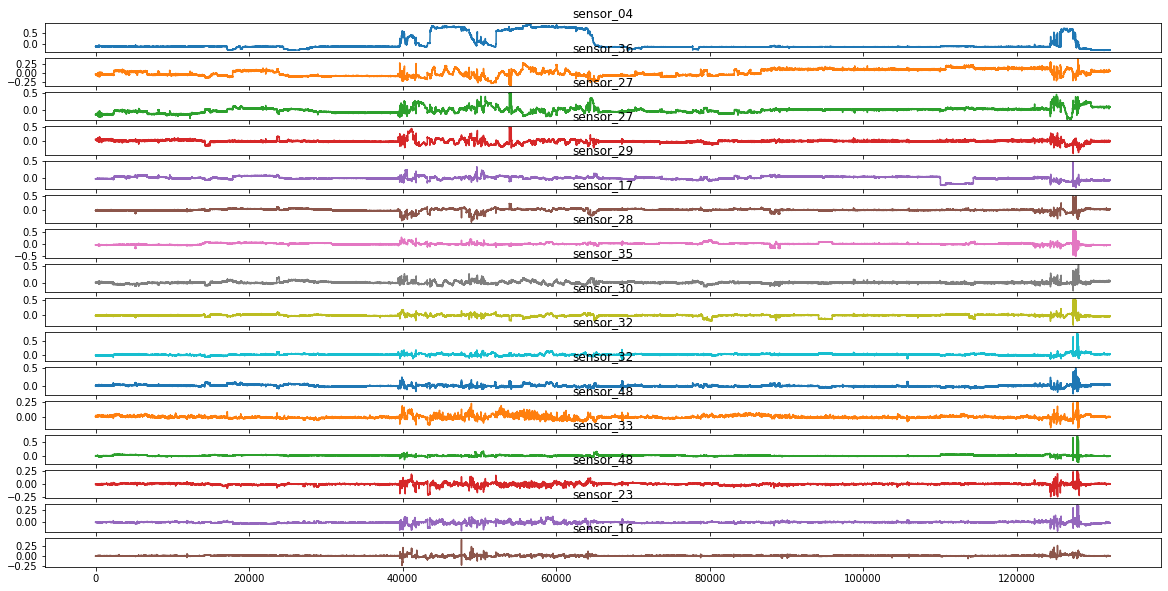

In [23]:
# this cell is hidden for easier readability

# replot the features we will use in the predictive model
pd.DataFrame(reduced_X_train).plot(subplots =True, 
                                   sharex = True, 
                                   figsize = (20,10),
                                   title = most_important_sensors, 
                                   legend = False);

Covariance shows you how the two variables differ, whereas correlation shows you how the two variables are related

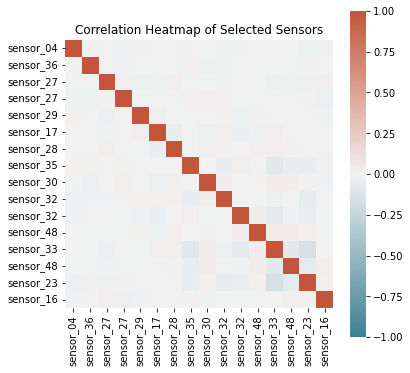

In [24]:
# This cell is hidden for easier readability

plt.figure(figsize = (6,6))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap((pd.DataFrame(reduced_X_train).sample(n=10000, replace=True, random_state=RANDOMSTATE)).corr(), 
            square = True, cmap = cmap, vmin = -1, vmax = 1,
            yticklabels = most_important_sensors, xticklabels = most_important_sensors)
plt.title('Correlation Heatmap of Selected Sensors');

In [25]:
#This cell is hidden for easier readability

# sns.heatmap(np.cov(reduced_X_train), 
#             center=0,
#             square=True, 
#             linewidths=.5, 
#             cbar_kws={"shrink": .5})

# sample 10,0000 values from the data so that we can create a covarianc matrix (otherwise its too large)
print('Covariance Matrix')
pd.DataFrame(reduced_X_train, columns=most_important_sensors).sample(n=10000, replace=True).cov()

Covariance Matrix


sensor_04  sensor_36  sensor_27  sensor_27  sensor_29  sensor_17  \
sensor_04   0.096803  -0.000197   0.000040   0.000019  -0.000071   0.000068   
sensor_36  -0.000197   0.008644   0.000115  -0.000012   0.000055   0.000033   
sensor_27   0.000040   0.000115   0.006427  -0.000054  -0.000013   0.000013   
sensor_27   0.000019  -0.000012  -0.000054   0.003698  -0.000076  -0.000018   
sensor_29  -0.000071   0.000055  -0.000013  -0.000076   0.002582   0.000021   
sensor_17   0.000068   0.000033   0.000013  -0.000018   0.000021   0.002203   
sensor_28   0.000179   0.000041  -0.000008  -0.000011   0.000015  -0.000061   
sensor_35  -0.000278   0.000006   0.000015   0.000021   0.000036  -0.000007   
sensor_30   0.000122   0.000031  -0.000034  -0.000010   0.000029  -0.000026   
sensor_32   0.000110  -0.000011   0.000024   0.000034   0.000025  -0.000026   
sensor_32   0.000004   0.000024   0.000008   0.000028  -0.000007  -0.000036   
sensor_48  -0.000328  -0.000002  -0.000017   0.000006   0.000015  -0.000027   
sensor_33  -0.000066   0.000006   0.000005   0.000007   0.000013  -0.000002   
sensor_48   0.000093   0.000007  -0.000033   0.000015  -0.000014  -0.000017   
sensor_23   0.000125   0.000013  -0.000063   0.000002   0.000008   0.000017   
sensor_16  -0.000003  -0.000026   0.000043   0.000060   0.000002  -0.000019   

           sensor_28     sensor_35  sensor_30     sensor_32     sensor_32  \
sensor_04   0.000179 -2.777430e-04   0.000122  1.096408e-04  3.743806e-06   
sensor_36   0.000041  6.395376e-06   0.000031 -1.140428e-05  2.429774e-05   
sensor_27  -0.000008  1.461318e-05  -0.000034  2.408786e-05  7.821894e-06   
sensor_27  -0.000011  2.068234e-05  -0.000010  3.441688e-05  2.766860e-05   
sensor_29   0.000015  3.608764e-05   0.000029  2.481843e-05 -7.114482e-06   
sensor_17  -0.000061 -7.041814e-06  -0.000026 -2.555318e-05 -3.558465e-05   
sensor_28   0.001539 -2.037935e-05   0.000014  4.991178e-05  2.777507e-05   
sensor_35  -0.000020  1.274196e-03   0.000019 -3.229286e-05 -2.433702e-05   
sensor_30   0.000014  1.886360e-05   0.001099  3.975950e-05  2.226424e-06   
sensor_32   0.000050 -3.229286e-05   0.000040  9.347434e-04  3.510907e-05   
sensor_32   0.000028 -2.433702e-05   0.000002  3.510907e-05  9.350032e-04   
sensor_48   0.000005 -1.535252e-05   0.000010 -1.159912e-05  2.005641e-05   
sensor_33   0.000012  4.787040e-06   0.000002 -3.674653e-07 -5.547632e-07   
sensor_48  -0.000003 -5.270035e-06  -0.000013 -1.542816e-05  8.959941e-06   
sensor_23  -0.000015 -3.001990e-05   0.000005  2.696878e-06 -8.696816e-06   
sensor_16   0.000009  9.695983e-07  -0.000004 -8.415407e-06 -9.603121e-06   

           sensor_48     sensor_33  sensor_48  sensor_23     sensor_16  
sensor_04  -0.000328 -6.612669e-05   0.000093   0.000125 -3.491489e-06  
sensor_36  -0.000002  5.862716e-06   0.000007   0.000013 -2.637461e-05  
sensor_27  -0.000017  4.722807e-06  -0.000033  -0.000063  4.278256e-05  
sensor_27   0.000006  7.190833e-06   0.000015   0.000002  6.016988e-05  
sensor_29   0.000015  1.259721e-05  -0.000014   0.000008  2.285873e-06  
sensor_17  -0.000027 -1.677920e-06  -0.000017   0.000017 -1.929828e-05  
sensor_28   0.000005  1.249291e-05  -0.000003  -0.000015  9.059263e-06  
sensor_35  -0.000015  4.787040e-06  -0.000005  -0.000030  9.695983e-07  
sensor_30   0.000010  1.576857e-06  -0.000013   0.000005 -4.212976e-06  
sensor_32  -0.000012 -3.674653e-07  -0.000015   0.000003 -8.415407e-06  
sensor_32   0.000020 -5.547632e-07   0.000009  -0.000009 -9.603121e-06  
sensor_48   0.000707  4.100761e-06  -0.000003  -0.000017  7.858224e-06  
sensor_33   0.000004  5.309360e-04  -0.000007  -0.000012 -5.846515e-07  
sensor_48  -0.000003 -7.020558e-06   0.000418  -0.000013 -1.941531e-05  
sensor_23  -0.000017 -1.163640e-05  -0.000013   0.000423 -8.394638e-06  
sensor_16   0.000008 -5.846515e-07  -0.000019  -0.000008  2.895480e-04

-----
# 3. Modeling 🦾

For this project we will try an unsupervised learning technique to try to predict failures by training a KMeans Clustering model. We will try many different parameters using GridSearchCV to find the best model. 

There are two types of predictive maintanence techniques: 
1. Regression Approach: Also known as remaining useful life (RUL), is when you try to predict how much time is left before the next failure.
2. Classification Approach: predicting the possibility of failure in the next n-steps. 


For this project, I wanted to use SKlearn's GridSearchCV to find the best parameters. However, this would make it difficult since gridsearchcv uses cross-validation. Since this is unsupervised learning we cannot use cross-validation as such. Additionally, the output will be numerical instead of string (i.e. "NORMAL", "BROKEN", "RECOVERING"). To be able to get the performance and find the best parameters, I decided to make my own function as follows. 

In [26]:
def label_permute_compare(y,ypred, n=3):
    """
    y: labels dataframe object
    pred: clustering label prediction output
    Returns permuted label order and accuracy. 
    """
    results = pd.DataFrame(y)
    perms = list(itertools.permutations([0, 1, 2]))      #create permutation list
    best_labels = []
    best_acc = 0 
    current = {}
    labels = ['NORMAL', 'BROKEN', 'RECOVERING']
    for perm in perms:
        for i in range(n):
            current[labels[i]] = perm[i]
            if len(current) == 3:
                conditions = [
                    (y['machine_status'] == current['NORMAL']),
                    (y['machine_status'] == current['BROKEN']),
                    (y['machine_status'] == current['RECOVERING'])]
                results['test'] = results['machine_status'].map(current)
                current_accuracy = accuracy_score(results['test'], ypred)
                if current_accuracy > best_acc: 
                    best_acc = current_accuracy
                    best_labels = perm
                    results['best'] = results['test']
    return best_labels, best_acc


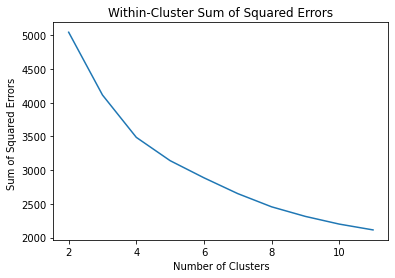

In [27]:
error = []
K = range(2,12)
for k in K:
    kmeans = KMeans(n_clusters = k, 
                    max_iter = 500, 
                    init = 'k-means++', 
                    n_init = 20, 
                    random_state = RANDOMSTATE)
    kmeans_fit = kmeans.fit(reduced_X_train)
    error.append(kmeans.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors ')
plt.title('Within-Cluster Sum of Squared Errors')
plt.plot(K,error);

In [28]:
# find best KMeans model parameters based on the training data
parameters = {'algorithm' : ['auto', 'elkan'], 
              'n_clusters':[3,4,5]}

model_results = {}
ytrue = pd.DataFrame(y_train, columns=['machine_status'])
for alg in parameters['algorithm']: 
    for n in parameters['n_clusters']:
        kmeans = KMeans(n_clusters = n,
                        algorithm = alg,
                        max_iter = 500, 
                        init = 'k-means++', 
                        random_state = RANDOMSTATE)
        kmeans.fit(reduced_X_train)
        ypred = kmeans.predict(reduced_X_train)
        best_labels, best_acc = label_permute_compare(ytrue,ypred, n=3)
        model_results[(alg, n)] = {'accuracy':round(best_acc, 4), 'labels': best_labels}

In [29]:
model_results

{('auto', 3): {'accuracy': 0.425, 'labels': (2, 0, 1)},
 ('auto', 4): {'accuracy': 0.3794, 'labels': (2, 0, 1)},
 ('auto', 5): {'accuracy': 0.3748, 'labels': (0, 1, 2)},
 ('elkan', 3): {'accuracy': 0.425, 'labels': (2, 0, 1)},
 ('elkan', 4): {'accuracy': 0.3794, 'labels': (2, 0, 1)},
 ('elkan', 5): {'accuracy': 0.3748, 'labels': (0, 1, 2)}}

The highest accuracy is with any parameter values, as long as n_clusters=3. Which is great and as we expected.

In [30]:
# train kmeans model with best parameters
kmeans = KMeans(n_clusters = 3, 
                algorithm = 'auto',
                init = 'k-means++',
                max_iter = 500,
                random_state = RANDOMSTATE)
kmeans.fit(reduced_X_train)

KMeans(max_iter=500, n_clusters=3, random_state=101)

In [31]:
# preprocess testing data as we did with the training data
X_cols = test.iloc[ : , 1:-1].columns
X_test = test.iloc[:,1:-1].copy()
y_test = test['machine_status']
X_test = X_test.fillna(method='ffill')
normalize = Normalizer(copy=True)
X_test = normalize.fit_transform(X_test[most_important_sensors])

In [32]:
#predict the testing set
ypred = kmeans.predict(X_test)
ytrue = pd.DataFrame(y_test, columns=['machine_status'])
best_labels, best_acc = label_permute_compare(ytrue,ypred, n=3)
print('Test Accuracy:', round(best_acc,4), '\n', 'Best labels:', best_labels)

Test Accuracy: 0.9444 
 Best labels: (2, 0, 1)


In [33]:
precision, recall, fscore, support = precision_recall_fscore_support(ytrue['best'], ypred, 
                                                                     zero_division=1, 
                                                                     average = 'micro')
print('Test Precision:', round(precision,4))
print('Test Recall:   ', round(recall, 4))

Test Precision: 0.9444
Test Recall:    0.9444


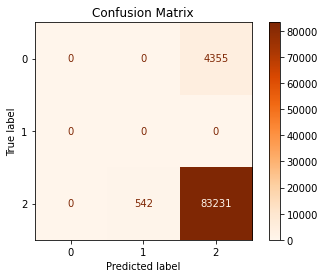

In [40]:
#create visual confusion matrix
ConfusionMatrixDisplay.from_predictions(ytrue['best'], ypred, cmap='Oranges')
plt.title('Confusion Matrix')
plt.show();

In [39]:
print(f'Unique values in test predictions: {list(np.unique(ypred))}')

Unique values in test predictions: [1, 2]


When looking at the performance metrics, we notice that statistically the model is  balanced because accuracy = precision = recall. This suggests that the model is able to correctly classify positive and negative samples at the same rate. However, it is misleading because not only does our model do quite poorly with performance, we must look at the confusion matrix to get an idea of what is happening. The cofusion matrix the columns as predicted and the rows as the actual. We see mostly zeros. In fact, it really only correctly predicted 1's and 2's which correspond (based on our best labels function) NORMAL and RECOVERING, respectively. What this means is that our model didn't even identify a single BROKEN in the test data (but we know there are two occurances). This is unfortunate because we were hoping for a model which would correctly identify when the pump is broken. However, we do notice that it correctly identified many 2's (which is the NORMAL). We could say that the model did very well identifying normal clusters, or, by understanding the data, we could argue that because almost all of the data was normal and comparatively only a small amount was recovering or broken that the model could have selected 2 (normal) for all occurances and gotten similar results. We will discuss this further in the conclusions section. 

------
# 4. Model Comparison 🤜🤛

We have a workable unsupervised learning model. However, we also want to compare it to other machine learning techniques. Let's compare it to two supervised learning models. For these models we will use the reduced version of the training and testing data, by applying the same preprocessing and dimensionality reduction technqiues. Then we will apply a clustering technique (K-nearest neighbors, KNN) to predict failure within a given timeframe and using a regression model to predict the remaining useful life (RUL) of the pump. 

In [43]:
# re-preprocess data to ensure fresh start of training and testing data
X_train = train.iloc[:,1:-1].copy()
y_train = train['machine_status']
X_train = X_train.fillna(method='ffill')
normalize = Normalizer()
X_train = normalize.fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X_cols
pca = PCA(n_components = .99, svd_solver = 'full', random_state = RANDOMSTATE )
pca.fit(X_train)
reduced_X_train = pca.transform(X_train)

most_important_sensors = [intital_features[most_important_comps[i]] for i in range(n_comps)]

X_test = test.iloc[:,1:-1].copy()
y_test = test['machine_status']
X_test = X_test.fillna(method='ffill')
normalize = Normalizer(copy=True)
X_test = normalize.fit_transform(X_test[most_important_sensors])

In [44]:
parameters = {'n_neighbors': [3, 5, 10], 
             'weights': ['uniform', 'distance'], 
             'algorithm': ['ball_tree', 'kd_tree'], 
             'p': [1, 2]}
grid_KNN = GridSearchCV(estimator = KNeighborsClassifier(), 
                        param_grid = parameters, 
                        cv = 3) 
grid_KNN.fit(reduced_X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree'],
                         'n_neighbors': [3, 5, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [46]:
best_param = grid_KNN.best_params_
print(best_param)

{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [47]:
# KNN train best model
KNN = KNeighborsClassifier(n_neighbors = best_param['n_neighbors'],
                          algorithm = best_param['algorithm'],
                          p = best_param['p'], 
                          weights = best_param['weights'])
KNN.fit(reduced_X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', p=1)

In [48]:
# test the testing set with KNN
ypred = KNN.predict(X_test)

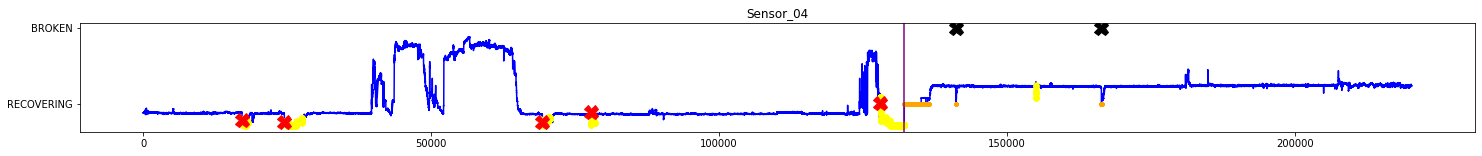

In [85]:
#Cell hidden for easier readability

# Visualize the clusters. 
# First combine the test and training into one
KNN_data = pd.DataFrame(np.concatenate((reduced_X_train, X_test)))
KNN_data.columns =  most_important_sensors
KNN_data['cluster'] = np.concatenate((y_train, ypred))
KNN_data['time'] = pd.to_datetime(sensor_data['timestamp'])
unique_elements, counts_elements = np.unique(ypred, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))
KNN_data['cluster_num'] = KNN_data['cluster'].map({'BROKEN': 0, 'NORMAL':1, 'RECOVERING':2})

colors = ['red', 'limegreen', 'yellow']
colors_plot = [colors[i] for i in KNN_data['cluster_num'].values]
sensors_to_plot = ['sensor_04']  #sensor 04 explains the most variance from the PCA model

#continue coloring 
broken_rows = KNN_data[KNN_data['cluster']=='BROKEN']
recovery_rows = KNN_data[KNN_data['cluster']=='RECOVERING']
normal_rows = KNN_data[KNN_data['cluster']=='NORMAL']
true_broken_rows = y_test[y_test=='BROKEN'] 
true_recovery_rows = y_test[y_test=='RECOVERING']

#create plot
plt.figure(figsize=(25,2))
plot = plt.plot(KNN_data['sensor_04'], color='blue', label='sensor data')
plot = plt.plot(recovery_rows['sensor_04'], linestyle='none', marker='o', color='yellow', markersize=5)
plot = plt.plot(broken_rows['sensor_04'], linestyle='none', marker='X', color='red', markersize=14)

plot = plt.plot(true_recovery_rows, linestyle='none', marker='o', color='orange', markersize=3)
plot = plt.plot(true_broken_rows, linestyle='none', marker='X', color='black', markersize=14)
plot = plt.axvline(x=132060, color='purple')

plot = plt.title('Sensor_04')
plt.show()

Let's examine this plot above. See the purple verticle line? That is where the training set ends and the test set begins. Yellow is where the model guessed the recovering status, red is broken and blue is normal. We see on the lefthand side (the training side) that the model did well which is expected because in a supervised learning model the model is given the training data with labels so of course it knows where the correct labels go. However, when we look to the right of the vertical line at the testing set, we see a different story. First, the model guessed recovering (yellow) where it should not have (orange is the true recovering values). Next, we see that model didn't predict any broken ocurrances (which should be red x's) however, we know where they should have been (black x). Note, the X is placed above the line for easier readability and reference with recovering values. Visually, it does not look like the model did well with the testing set but let's look at the performance metrics too.

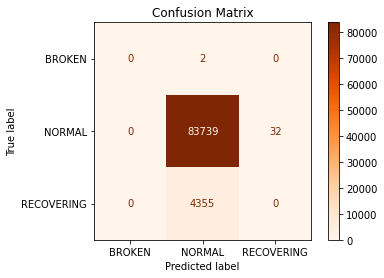

KNN Test Results
Test Accuracy: 0.9502
Test Precision: 0.9502
Test Recall: 0.9502


In [55]:
# show test statistics and results
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_test, ypred, cmap='Oranges')
plt.title('Confusion Matrix')
plt.show();
acc = accuracy_score(y_test, ypred)
precision, recall, fscore, support = precision_recall_fscore_support(y_test, ypred, 
                                                                     zero_division=1, 
                                                                     average = 'micro')
print('KNN Test Results')
print('Test Accuracy:', round(acc, 4))
print('Test Precision:', round(precision, 4))
print('Test Recall:', round(recall, 4))

We can see with our supervised learning model that it actually did very similiarly to our unsupervised model (but we will discuss this more in the next session). We can see that, like the Kmeans model, our KNN model only guessed NORMAL and RECOVERING. Both models seemed to have struggled identifying BROKEN into clusters. We see that again accuracy = precision = recall which could mean that the model is a well-balanced model in normal circumstances however, as expressed for KMeans we see that the model is mostly guessing normal and probably would have gotten similar results if it only guessed NORMAL because the data is so unbalanced. 

### Comparison



------
# 5. Conclusion and Future Suggestions 👏

Let's review what we did in this project. First we explored the data given to us and visualized it. It is suggested not to view all the data before splitting into testing and training sets but for learning experience and this project specifically, we decided to look at it all first. Then we visualized the data to get a better since of the patterns. Next, we did data preprocessing by dealing with missing data with forward-fill propogation. We used PCA to find the most useful features (columns) to use when trainging the models. We then trained many KMeans and KNN models and found the best one for each. Finally, we compared the models performance. Overall we used three models: two unsupervised models including PCA and KMeans Clusters and one supervised model using KNN. 

Future suggestions 

_______
# References and Useful Links

https://medium.com/bigdatarepublic/machine-learning-for-predictive-maintenance-where-to-start-5f3b7586acfb

https://medium.com/@polanitzer/prediction-of-remaining-useful-life-of-an-engine-based-on-sensors-building-a-random-forest-in-ffad82c8a1c6

https://towardsdatascience.com/feature-extraction-using-principal-component-analysis-a-simplified-visual-demo-e5592ced100a

https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering

https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

https://www.youtube.com/watch?v=AS0H43hMoWM&t=1430s


END